In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

import dqn_agent
#from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
#from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [6]:
env_name = 'CartPole-v1'  # @param
num_iterations = 10000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [7]:
env = suite_gym.load(env_name)

In [8]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [10]:
from tf_agents.networks import network

class DDQN(network.Network):
    def __init__(self, observation_spec, action_spec, name="DDQN"):
        super(DDQN, self).__init__(
            input_tensor_spec=observation_spec,
            state_spec=(),
            name=name)    
        
        hidden_units = 32
        action_spec = tf.nest.flatten(action_spec)[0]
        num_actions = action_spec.maximum - action_spec.minimum + 1
        
        # Shared layers
        self._shared1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
     
        self._shared2 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')

        # Learn advantage
        self._adv1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._adv2 = tf.keras.layers.Dense(num_actions, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        self._adv3 = tf.keras.layers.Lambda(lambda a: a - tf.keras.backend.mean(a, axis=1, keepdims=True), 
                                            output_shape=(num_actions,))
        
        # Learn value
        self._value1 = tf.keras.layers.Dense(hidden_units, 
                         activation='relu', 
                         kernel_initializer='he_uniform')
        self._value2 = tf.keras.layers.Dense(1, 
                         activation='linear', 
                         kernel_initializer='he_uniform')
        
        # Combine into Q
        self._q_out = tf.keras.layers.Add()

    def call(self, observation, step_type=None, network_state=()):
        shared = self._shared1(observation)
        shared = self._shared2(shared)
        adv = self._adv1(shared)
        adv = self._adv2(adv)
        adv = self._adv3(adv)
        value = self._value1(shared)
        value = self._value2(shared)
        q_out = self._q_out([adv, value])
        return q_out, network_state

In [11]:
q_net = DDQN(
    train_env.observation_spec(),
    train_env.action_spec())

#q_net = q_network.QNetwork(
#    train_env.observation_spec(),
#    train_env.action_spec(),
#    fc_layer_params=fc_layer_params)

In [12]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

collect policy is e-greedy


In [13]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [14]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [15]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [16]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [17]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, tf_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


W0710 07:38:04.869653 4437706176 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tf_agents/policies/epsilon_greedy_policy.py:96: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


td_errors_loss_fn=<function element_wise_squared_loss at 0x137364e18>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
td_errors_loss_fn=<function element_wise_squared_loss at 0x137364e18>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
step = 200: loss = 32.989261627197266
step = 400: loss = 234.93902587890625
step = 600: loss = 76.19415283203125
step = 800: loss = 31.17449188232422
step = 1000: loss = 114.59101867675781
step = 1000: Average Return = 33.0
step = 1200: loss = 56.44641876220703
step = 1400: loss = 297.5062561035156
step = 1600: loss = 255.69776916503906
step = 1800: loss = 546.0511474609375
step = 2000: loss = 151.6051483154297
step = 2000: Average Return = 99.69999694824219
step = 2200: loss = 747.3446044921875
step = 2400: loss = 279.80804443359375
step = 2600: loss = 1948.718017578125
step = 2800: loss = 336.2585144042969
step = 3000: loss = 746.2692260742

(6.694999694824219, 550)

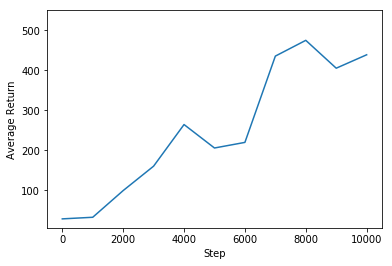

In [21]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [22]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = tf_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()

In [ ]:
def _experience_to_transitions(experience):
    transitions = trajectory.to_transition(experience)

    transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]), transitions)

    time_steps, policy_steps, next_time_steps = transitions
    actions = policy_steps.action
    return time_steps, actions, next_time_steps

def element_wise_squared_loss(x, y):
    return tf.compat.v1.losses.mean_squared_error(x, y, reduction=tf.compat.v1.losses.Reduction.NONE)

def element_wise_huber_loss(x, y):
    return tf.compat.v1.losses.huber_loss(x, y, reduction=tf.compat.v1.losses.Reduction.NONE)

def compute_td_targets(next_q_values, rewards, discounts):
    return tf.stop_gradient(rewards + discounts * next_q_values)

def index_with_actions(q_values, actions, multi_dim_actions=False):
    if actions.shape.ndims is None:
        raise ValueError('actions should have known rank.')
    
    batch_dims = actions.shape.ndims
    if multi_dim_actions:
        # In the multidimensional case, the last dimension of actions indexes the
        # vector of actions for each batch, so exclude it from the batch dimensions.
        batch_dims -= 1

    outer_shape = tf.shape(input=actions)
    batch_indices = tf.meshgrid(*[tf.range(outer_shape[i]) for i in range(batch_dims)], indexing='ij')
    batch_indices = [
        tf.expand_dims(batch_index, -1) for batch_index in batch_indices
    ]
    
    if not multi_dim_actions:
        actions = tf.expand_dims(actions, -1)
        
    action_indices = tf.concat(batch_indices + [actions], -1)
    return tf.gather_nd(q_values, action_indices)

def _compute_next_q_values(self, next_time_steps):
    next_target_q_values, _ = self._target_q_network(next_time_steps.observation, next_time_steps.step_type)
    return tf.reduce_max(input_tensor=next_target_q_values, axis=-1)

def _loss(self, experience, reward_scale_factor=1.0, gamma = 1.0):
    time_steps, actions, next_time_steps = self._experience_to_transitions(experience)

    with tf.name_scope('loss'):
        actions = tf.nest.flatten(actions)[0]
        q_values, _ = self._q_network(time_steps.observation, time_steps.step_type)

        print("ndims={}".format(tf.nest.flatten(self._action_spec)[0].shape.ndims))
        multi_dim_actions = tf.nest.flatten(self._action_spec)[0].shape.ndims > 0
        q_values = index_with_actions(q_values,
                                      tf.cast(actions, dtype=tf.int32),
                                      multi_dim_actions=multi_dim_actions)

        next_q_values = self._compute_next_q_values(next_time_steps)

        td_targets = compute_td_targets(next_q_values,
                                        rewards=reward_scale_factor * next_time_steps.reward,
                                        discounts=gamma * next_time_steps.discount)

        valid_mask = tf.cast(~time_steps.is_last(), tf.float32)
        td_error = valid_mask * (td_targets - q_values)

        td_loss = valid_mask * element_wise_squared_loss(td_targets, q_values)

        loss = tf.reduce_mean(input_tensor=td_loss)

        return loss, td_loss, td_error
    
def _train(self, experience):
    with tf.GradientTape() as tape:
        loss, td_loss, td_error = _loss(self, experience)
    variables_to_train = self._q_network.trainable_weights
    grads = tape.gradient(loss, variables_to_train)
    # Tuple is used for py3, where zip is a generator producing values once.
    grads_and_vars = tuple(zip(grads, variables_to_train))
    self._optimizer.apply_gradients(grads_and_vars,
                                    global_step=self.train_step_counter)

    self._update_target()

    return loss, td_loss, td_error

In [ ]:
experience, unused_info = next(iterator)

loss, td_loss, td_error = _train(tf_agent, experience)

In [ ]:
print(loss)
print(td_loss)
print(td_error)